## Model Metrics Analysis for LLaMa-2 benchmarking
---------
*This notebook works best with the conda_python3 kernel on a ml.t3.medium machine*.

### This part of our solution design includes the chunk of taking the metrics generated and creating visualizations from it for further analysis to make decisions more quicker, efficient, and cost optimal.

- In this file, we will go over and create side by side visualizations of different models deployed, how their inference latency is impacted based on the concurrency level, instance size and different model configurations. Using these visualizations and charts, making executive decisions, saving on time and cost becomes critical. 


- In this notebook, we will also record the error rates for each of the deployed model endpoints based on how it ran against different metrics as specified above. These visualizations will be applicable and work for any and every jumpstart and non jumpstart model if deployed correctly using the prior steps.

In [53]:
## auto reload all of the changes made in the config/globals.py file 
!touch globals.py
%reload_ext autoreload

#### Import all of the necessary libraries below to run this notebook

In [54]:
import glob
import time
import json
import copy
import asyncio
import io
import logging
import itertools
import sagemaker
import numpy as np
import pandas as pd
from utils import write_to_s3

## Import seaborn and other related libraries for visualizations and plotting charts
import seaborn as sns
from globals import *
from datetime import datetime
from typing import Dict, List
from transformers import AutoTokenizer
from sagemaker.predictor import Predictor
from utils import load_config, count_tokens
from sagemaker.serializers import JSONSerializer

In [55]:
# Importing the necessary libraries for data visualization
import seaborn as sns # enhanced visualization capabilities

## for plotting
import matplotlib.pyplot as plt
# rcParams for configuring Matplotlib settings
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10, 6

#### Pygmentize globals.py to view and use any of the globally initialized variables 

In [56]:
# global constants
!pygmentize globals.py

import os
import yaml
from enum import Enum
from pathlib import Path
import boto3

CONFIG_FILEPATH_FILE: str = "config_filepath.txt"

# S3 client initialization
s3_client = boto3.client('s3')

CONFIG_FILE: str = Path(CONFIG_FILEPATH_FILE).read_text()
print(f"CONFIG_FILE={CONFIG_FILE}")
with open(CONFIG_FILE, 'r') as file:
    config = yaml.safe_load(file)

DATA_DIR: str = "data"
PROMPTS_DIR = os.path.join(DATA_DIR, "prompts")
METRICS_DIR = os.path.join(DATA_DIR, "metrics", config['general']['name'])
METRICS_PER_INFERENCE_DIR  = os.path.join(METRICS_DIR, "per_inference")
METRICS_PER_CHUNK_DIR  = os.path.join(METRICS_DIR, "per_chunk")

# MODELS_DIR = os.path.join(DATA_DIR, "models", config['general']['name'])
MODELS_DIR = config['aws']['prefix'] + "/models"

## DEFINE THE S3 PATH FOR ENDPOINTS TO READ FROM DURING RUN INFERENCE
ENDPOINT_S3_PATH = f"{MODELS_DIR}/{config['general']['name']}/endpoints.json"

## Use this to upload to the s3 bucket (extracted from the config file)
BUCKET_NAME 

In [57]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Load the Config.yml file contains information that is used across this benchmarking environment, such as information about the aws account, prompts, payloads to be used for invocations

In [58]:
config = load_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-01-26 23:47:45,680] p14771 {635462509.py:2} INFO - {
  "general": {
    "name": "mistral-7b-tgi-g5-v1",
    "model_name": "mistral7b"
  },
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:iam::218208277580:role/service-role/AmazonSageMaker-ExecutionRole-20230807T175994",
    "bucket": "fmbt",
    "prefix": "data",
    "source_data_bucket_prefix": "source_data",
    "prompt_template": "prompt_template/prompt_template.txt",
    "custom_tokenizer": "tokenizer",
    "bring_your_script": "byo_script"
  },
  "prompt": {
    "template_file": "prompt_template.txt",
    "all_prompts_file": "all_prompts.csv"
  },
  "datasets": [
    {
      "language": "en",
      "min_length_in_tokens": 1,
      "max_length_in_tokens": 500,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 500,
      "max_length_in_tokens": 1000,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
    

In [59]:
# make a local copy of the config in the metrics dir so that the results markdown has easy access and we can 
# have a complete results package with the config AND the results
logger.info(f"CONFIG_FILE={CONFIG_FILE}")
local_config_copy = os.path.join(METRICS_DIR, os.path.basename(CONFIG_FILE))
logger.info(f"saving a copy of the config in {local_config_copy}")
with open(local_config_copy, 'w') as yaml_file:
    yaml.dump(config, yaml_file)


[2024-01-26 23:47:45,686] p14771 {144294996.py:3} INFO - CONFIG_FILE=configs/config-mistral-7b-tgi-g5.yml
[2024-01-26 23:47:45,688] p14771 {144294996.py:5} INFO - saving a copy of the config in data/metrics/mistral-7b-tgi-g5-v1/config-mistral-7b-tgi-g5.yml


In [60]:
file_path = os.path.join(METRICS_DIR, config["results"]["per_inference_request_file"])

# Read the file from S3
try:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=file_path)
    file_content = response['Body'].read().decode('utf-8')

    # Use pandas to read the CSV content
    df_per_inference = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{file_path} read into dataframe of shape {df_per_inference.shape}")
    df_per_inference.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

df_per_inference.head()

[2024-01-26 23:47:46,044] p14771 {3929633270.py:10} INFO - data/metrics/mistral-7b-tgi-g5-v1/per_inference_request_results.csv read into dataframe of shape (42, 29)


,endpoint_name,prompt,do_sample,temperature,top_p,top_k,max_new_tokens,truncate,completion,prompt_tokens,...,ENDPOINT_SERVER_TIMEOUT,HF_MODEL_ID,MAX_BATCH_PREFILL_TOKENS,MAX_INPUT_LENGTH,MAX_TOTAL_TOKENS,MODEL_CACHE_ROOT,SAGEMAKER_ENV,SAGEMAKER_MODEL_SERVER_WORKERS,SAGEMAKER_PROGRAM,SM_NUM_GPUS
0,lmistral7b-g5-2xlarge-1706329863,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.1,0.92,120,100,304,\n\n```\nThe genus Sinofranchetia is from the ...,304,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
1,lmistral7b-g5-2xlarge-1706329863,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.1,0.92,120,100,980,Both WAGS Atlanta and WAGS are reality televi...,980,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
2,lmistral7b-g5-2xlarge-1706329863,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.1,0.92,120,100,304,\n\n```\nThe genus Sinofranchetia and Staunton...,304,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
3,lmistral7b-g5-2xlarge-1706329863,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.1,0.92,120,100,304,\n\n```\nThe genus Sinofranchetia is from the ...,304,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
4,lmistral7b-g5-2xlarge-1706329863,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.1,0.92,120,100,980,Both WAGS Atlanta and WAGS are reality televi...,980,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1


### Relationship between prompt token length and inference latency for different instances and concurrency levels

[2024-01-26 23:47:47,307] p14771 {2626749833.py:35} INFO - Plot saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/tokens_vs_latency.png


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/tokens_vs_latency.png


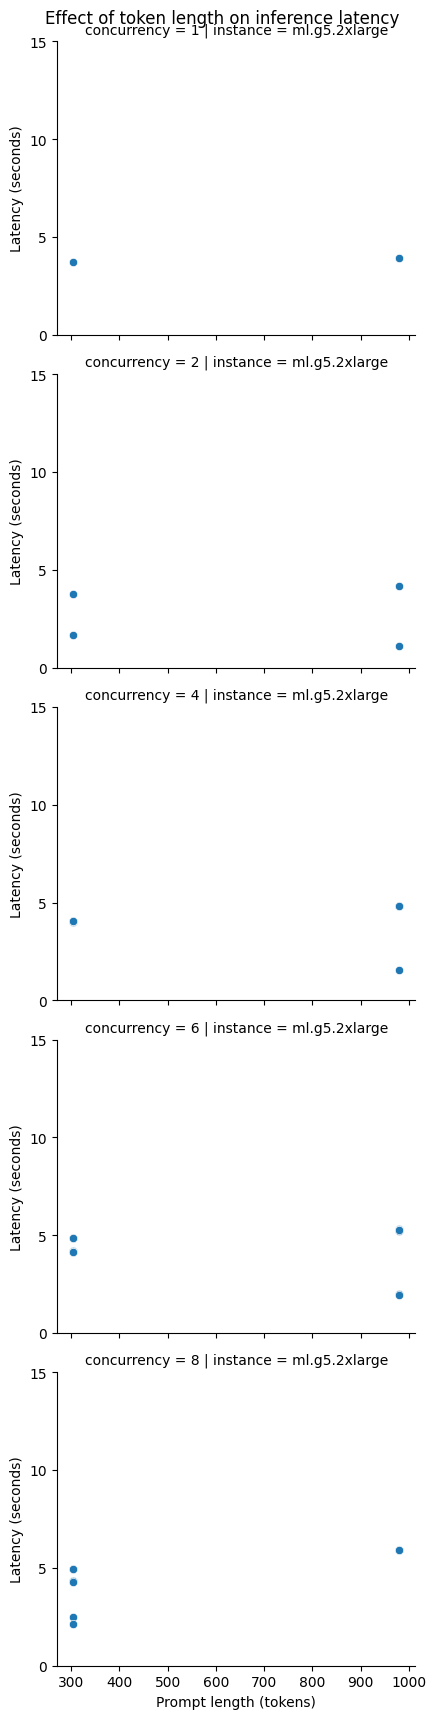

In [61]:
# Rename a column in the dataframe for clarity of the instance parameter of the model used
df_per_inference = df_per_inference.rename(columns={"instance_type": "instance"})


# This created a FacetGrid for plotting multiple scatter plots based on 'instance' and 'concurrency' categories
g = sns.FacetGrid(df_per_inference, col="instance", row="concurrency", hue="instance", height=3.5, aspect=1.25)

## Subtitle of the facetgrid
g.fig.suptitle("Effect of token length on inference latency")

# # This will map a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "prompt_tokens", "latency")

# Set the y-axis label for all plots
g = g.set_ylabels("Latency (seconds)")

# Y-axis ticks based on the maximum latency value and setting them in that manner
yticks: List = list(range(0, (int(df_per_inference.latency.max())//10+2)*10, 5))
g = g.set(yticks=yticks)

# Set the x-axis label for all plots as the prompt length or tokens
g = g.set_xlabels("Prompt length (tokens)")

# Create a bytes buffer to save the plot
buffer = io.BytesIO()
sns_plot.savefig(buffer, format='png')
buffer.seek(0)  # Rewind buffer to the beginning

# Specify the S3 path and file name for the plot
plot_file_name = TOKENS_VS_LATENCY_PLOT_FNAME
plot_s3_path = os.path.join(METRICS_DIR, plot_file_name)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, plot_file_name)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{plot_s3_path}")

# Optionally, display the plot
sns_plot

#### Define the all metrics file path and read it to generate visualizations

In [62]:
# all_metrics_fpath: str = os.path.join(METRICS_DIR, config["results"]["all_metrics_file"])

# df_all_metrics = pd.read_csv(all_metrics_fpath)
# logger.info(f"{all_metrics_fpath} contains {df_all_metrics.shape[0]} results")
# df_all_metrics.head()

all_metrics_fpath = os.path.join(METRICS_DIR, config["results"]["all_metrics_file"])

# Read the file from S3
try:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=all_metrics_fpath)
    file_content = response['Body'].read().decode('utf-8')

    # Use pandas to read the CSV content
    df_all_metrics = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{all_metrics_fpath} read into dataframe of shape {df_all_metrics.shape}")
    df_all_metrics.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

df_all_metrics.head()

[2024-01-26 23:47:47,613] p14771 {2213641313.py:16} INFO - data/metrics/mistral-7b-tgi-g5-v1/all_metrics.csv read into dataframe of shape (10, 31)


,experiment_name,concurrency,payload_file,errors,successes,error_rate,all_prompts_token_count,prompt_token_count_mean,prompt_token_throughput,all_completions_token_count,...,ENDPOINT_SERVER_TIMEOUT,HF_MODEL_ID,MAX_BATCH_PREFILL_TOKENS,MAX_INPUT_LENGTH,MAX_TOTAL_TOKENS,MODEL_CACHE_ROOT,SAGEMAKER_ENV,SAGEMAKER_MODEL_SERVER_WORKERS,SAGEMAKER_PROGRAM,SM_NUM_GPUS
0,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,1,payload_en_1-500.jsonl,[],1,0.0,304,304.0,79.07,98,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
1,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,1,payload_en_500-1000.jsonl,[],1,0.0,980,980.0,248.06,100,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
2,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,2,payload_en_1-500.jsonl,[],2,0.0,608,304.0,161.40,138,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
3,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,2,payload_en_500-1000.jsonl,[],2,0.0,1960,980.0,470.13,116,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,4,payload_en_1-500.jsonl,[],4,0.0,1216,304.0,299.26,398,...,3600,/opt/ml/model,8191,8191,8192,/opt/ml/model,1,1,inference.py,1


In [63]:
## displaying all of the available columns in the all metrics dataframe
df_all_metrics.columns

Index(['experiment_name', 'concurrency', 'payload_file', 'errors', 'successes',
       'error_rate', 'all_prompts_token_count', 'prompt_token_count_mean',
       'prompt_token_throughput', 'all_completions_token_count',
       'completion_token_count_mean', 'completion_token_throughput',
       'transactions', 'transactions_per_second', 'transactions_per_minute',
       'latency_mean', 'instance_type', 'EndpointName', 'ModelName', 'Image',
       'S3Uri', 'ENDPOINT_SERVER_TIMEOUT', 'HF_MODEL_ID',
       'MAX_BATCH_PREFILL_TOKENS', 'MAX_INPUT_LENGTH', 'MAX_TOTAL_TOKENS',
       'MODEL_CACHE_ROOT', 'SAGEMAKER_ENV', 'SAGEMAKER_MODEL_SERVER_WORKERS',
       'SAGEMAKER_PROGRAM', 'SM_NUM_GPUS'],
      dtype='object')

#### Display the number of experiment names within the metrics dataframe, instance types and models

In [64]:
experiments = df_all_metrics.experiment_name.unique()
instance_types = df_all_metrics.instance_type.unique()
model_names = df_all_metrics.ModelName.unique()
logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types, {len(model_names)} models")

[2024-01-26 23:47:48,022] p14771 {369708136.py:4} INFO - contains information about 1 experiments, 1 instance types, 1 models


In [65]:
## extract some of the columns
relevant_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                       'concurrency',
                         'error_rate',
                           'prompt_token_count_mean',
                             'prompt_token_throughput',
                               'completion_token_count_mean',
                                 'completion_token_throughput',
                                   'latency_mean',
                                     'transactions_per_minute']

## initialize a group by columns to use further in generating portions of the dataframe and filtering it
group_by_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'concurrency']


#### Create an 'experiment_counts.csv' to store metrics on experiment name, the pauloaf file, concurrency and the total counts associated to that given experiment to visualize the distribution

In [66]:
# COUNTS_FNAME: str = "experiment_counts.csv"
# fpath: str = os.path.join(METRICS_DIR, COUNTS_FNAME)
df_counts = df_all_metrics[group_by_cols].value_counts().reset_index()
# df_counts.to_csv(fpath, index=False)
# df_counts

# Convert df_counts to CSV format
csv_buffer = io.StringIO()
df_counts.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Define the file name and the S3 path
COUNTS_FNAME = "experiment_counts.csv"
counts_s3_path = os.path.join(METRICS_DIR, COUNTS_FNAME)

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, COUNTS_FNAME)
logger.info(f"Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_counts



[2024-01-26 23:47:49,384] p14771 {684866909.py:18} INFO - Counts DataFrame saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/experiment_counts.csv


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/experiment_counts.csv


,experiment_name,payload_file,instance_type,concurrency,count
0,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,1,1
1,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,2,1
2,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,4,1
3,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,6,1
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,8,1
5,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,1,1
6,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,2,1
7,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,4,1
8,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,6,1
9,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,1


#### Display the mean error rates for each experiment with different congifurations using the same columns of interest used in the cell above

In [67]:
# ERROR_RATES_FNAME: str = "error_rates.csv"
# fpath: str = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)
df_error_rates = df_all_metrics.groupby(group_by_cols).agg({'error_rate': 'mean'}).reset_index()
df_error_rates = df_error_rates.round(2)
# df_error_rates.to_csv(fpath, index=False)
# df_error_rates





df_error_rates.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Define the file name and the S3 path
ERROR_RATES_FNAME: str = "error_rates.csv"
counts_s3_path = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, ERROR_RATES_FNAME)
logger.info(f"Error Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_error_rates

[2024-01-26 23:47:50,441] p14771 {1475599444.py:21} INFO - Error Counts DataFrame saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/error_rates.csv


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/error_rates.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate
0,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,1,0.0
1,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,2,0.0
2,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,4,0.0
3,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,6,0.0
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,8,0.0
5,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,1,0.0
6,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,2,0.0
7,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,4,0.0
8,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,6,0.0
9,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0


### Visualize Inference error rates across different concurrency levels and instance types

[2024-01-26 23:47:52,113] p14771 {1752248061.py:26} INFO - Plot saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/error_rates.png


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/data/metrics/mistral-7b-tgi-g5-v1/error_rates.png


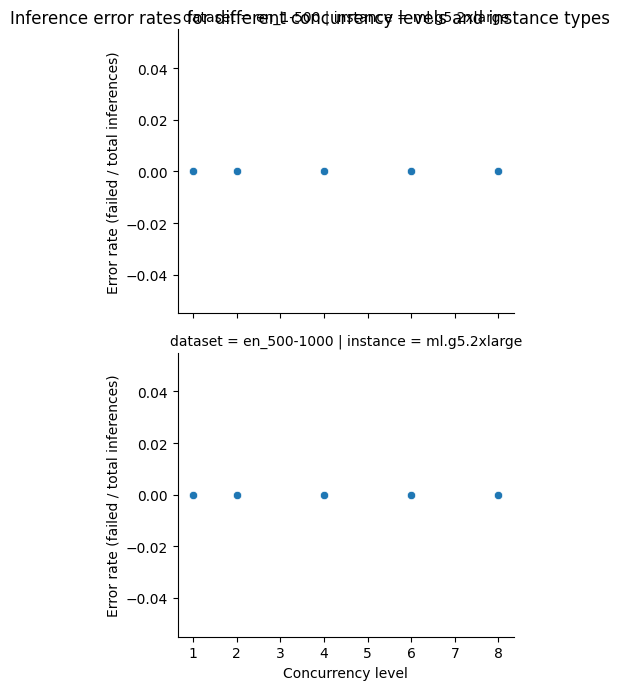

In [68]:
df_error_rates = df_error_rates.rename(columns={"instance_type": "instance", "payload_file": "dataset"})

# Clean up the dataset names by removing json file extensions and prefixes
df_error_rates.dataset = df_error_rates.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))

# this creates a facetGrid for plotting scatter plots based on 'instance' and 'dataset'
g = sns.FacetGrid(df_error_rates, col="instance", row="dataset", hue="instance", height=3.5, aspect=1.25)

# Maps a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "concurrency", "error_rate")

# Create a subtitle
g.fig.suptitle("Inference error rates for different concurrency levels and instance types")

## Set x and y labels for this chart
g = g.set_ylabels("Error rate (failed / total inferences)")
g = g.set_xlabels("Concurrency level")


plot_s3_path = os.path.join(METRICS_DIR, ERROR_RATES_PLOT_FNAME)
sns_plot.savefig(buffer, format='png')
buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, plot_s3_path)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{plot_s3_path}")

## Display the plot 
sns_plot




#### Check for the df elements that have error rates above 0

In [69]:
df_error_rates_nz = df_error_rates[df_error_rates.error_rate > 0]
df_error_rates_nz

,experiment_name,dataset,instance,concurrency,error_rate


In [70]:
## initialize a dataframe to get the mean of the columns in consideration
df_summary_metrics = df_all_metrics[relevant_cols].groupby(group_by_cols).mean().reset_index()

# ugly way of doing this, will refactor this later (maybe)
df_summary_metrics.fillna(PLACE_HOLDER, inplace=True)
int_cols = ['prompt_token_count_mean', 'prompt_token_throughput', 'completion_token_count_mean', 'completion_token_throughput', 'transactions_per_minute']
for ic in int_cols:
    df_summary_metrics[ic] = df_summary_metrics[ic].astype(int)

df_summary_metrics.replace(PLACE_HOLDER, np.nan, inplace=True)
df_summary_metrics.latency_mean	= df_summary_metrics.latency_mean.round(2)
df_summary_metrics.error_rate	= df_summary_metrics.error_rate.round(2)

# fpath: str = all_metrics_fpath.replace("all_metrics", "all_metrics_summary")

# df_summary_metrics.to_csv(fpath, index=False)
# df_summary_metrics

df_summary_metrics.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Define the file name for S3 based on the original file path
summary_file_name = all_metrics_fpath.replace("all_metrics", "all_metrics_summary").split('/')[-1] 
summary_s3_path = os.path.join(METRICS_DIR, summary_file_name)  # Define full S3 path

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, summary_file_name)
logger.info(f"Summary metrics DataFrame saved to s3://{BUCKET_NAME}/{summary_s3_path}")

df_summary_metrics

[2024-01-26 23:47:53,791] p14771 {4227015848.py:28} INFO - Summary metrics DataFrame saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/all_metrics_summary.csv


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/all_metrics_summary.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute
0,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,1,0.0,304,79,98,25,3.75,15
1,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,2,0.0,304,161,69,36,2.70,31
2,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,4,0.0,304,299,99,97,4.03,58
3,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,6,0.0,304,374,100,123,4.40,73
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_1-500.jsonl,ml.g5.2xlarge,8,0.0,304,482,85,136,3.96,95
5,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,1,0.0,980,248,100,25,3.94,15
6,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,2,0.0,980,470,58,27,2.62,28
7,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,4,0.0,980,813,79,65,3.98,49
8,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,6,0.0,980,1102,72,81,4.16,67
9,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80


In [71]:
df_summary_metrics_nz = df_summary_metrics[df_summary_metrics.error_rate == 0]
logger.info(f"there are {len(df_summary_metrics_nz)} entries out of {len(df_summary_metrics)} in the summary data for which error rate is 0")

[2024-01-26 23:47:54,167] p14771 {3483828648.py:2} INFO - there are 10 entries out of 10 in the summary data for which error rate is 0


In [72]:
df_summary_metrics_dataset = df_summary_metrics[df_summary_metrics.payload_file.str.contains(config['metrics']['dataset_of_interest'])]
logger.info(f"shape of dataframe with summary metrics for {config['metrics']['dataset_of_interest']} is {df_summary_metrics_dataset.shape}")

df_summary_metrics_dataset.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_W_PRICING_FNAME)
logger.info(f"Summary metrics dataset saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{SUMMARY_METRICS_W_PRICING_FNAME}")

df_summary_metrics_dataset

[2024-01-26 23:47:54,733] p14771 {381626756.py:2} INFO - shape of dataframe with summary metrics for en_500-1000 is (5, 11)
[2024-01-26 23:47:55,022] p14771 {381626756.py:9} INFO - Summary metrics dataset saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_w_pricing.csv


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_w_pricing.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute
5,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,1,0.0,980,248,100,25,3.94,15
6,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,2,0.0,980,470,58,27,2.62,28
7,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,4,0.0,980,813,79,65,3.98,49
8,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,6,0.0,980,1102,72,81,4.16,67
9,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80


[2024-01-26 23:47:55,358] p14771 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2024-01-26 23:47:55,363] p14771 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['ml.g5.2xlarge']


[2024-01-26 23:47:56,125] p14771 {4019277021.py:23} INFO - Plot saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/error_rates.png


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/concurrency_vs_inference_latency.png


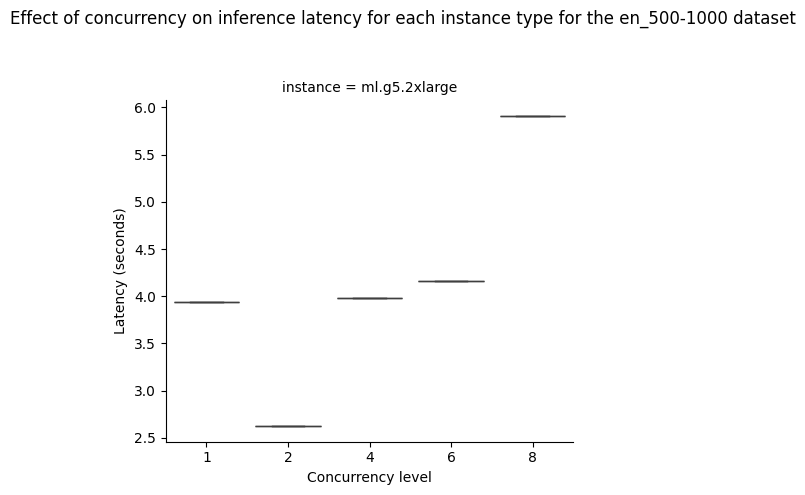

In [73]:
df_all_metrics_for_dataset = df_all_metrics.rename(columns={"instance_type": "instance", "payload_file": "dataset"})
df_all_metrics_for_dataset.dataset = df_all_metrics_for_dataset.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))
ds = config['metrics']['dataset_of_interest']
df_all_metrics_for_dataset = df_all_metrics_for_dataset[df_all_metrics_for_dataset.dataset.str.contains(ds)]
# df_all_metrics_for_dataset.concurrency = df_all_metrics_for_dataset.concurrency.astype(str)
row_order = list(df_all_metrics_for_dataset[["instance", "latency_mean"]].groupby("instance").mean("latency_mean").reset_index()["instance"])
print(row_order)
sns_plot = sns.catplot(
    data=df_all_metrics_for_dataset, x='concurrency', y='latency_mean',
    col='instance', kind='box', col_wrap=len(row_order), hue="instance", row_order=row_order #, height=4.5, aspect=1.25
)
sns_plot._legend.remove()
sns_plot.fig.suptitle(f"Effect of concurrency on inference latency for each instance type for the {ds} dataset\n\n")
sns_plot = sns_plot.set_ylabels("Latency (seconds)")
sns_plot = sns_plot.set_xlabels("Concurrency level")
sns_plot.fig.subplots_adjust(top=0.8)

sns_plot.savefig(buffer, format='png')
buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{plot_s3_path}")

In [74]:
df_pricing = pd.DataFrame.from_dict(config['pricing'], orient='index').reset_index()
df_pricing.columns = ['instance_type', 'price_per_hour']
# fpath: str = os.path.join(METRICS_DIR, INSTANCE_PRICING_PER_HOUR_FNAME)

df_pricing.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, INSTANCE_PRICING_PER_HOUR_FNAME)

df_pricing

Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/instance_pricing_per_hour.csv


,instance_type,price_per_hour
0,ml.g5.2xlarge,1.515
1,ml.g5.12xlarge,7.090
2,ml.g5.24xlarge,10.180
3,ml.g5.48xlarge,20.360
4,ml.inf2.24xlarge,7.790
5,ml.inf2.48xlarge,15.580
6,ml.p4d.24xlarge,37.688


In [75]:
df_summary_metrics_dataset = pd.merge(df_summary_metrics_dataset, df_pricing, how='left')

df_summary_metrics_dataset['price_per_txn'] = (df_summary_metrics_dataset['price_per_hour']/60)/df_summary_metrics_dataset['transactions_per_minute']
price_per_tx_wt = config['metrics']['weights']['price_per_tx_wt']
latency_wt = config['metrics']['weights']['latenct_wt']
#df_summary_metrics_dataset['score'] = price_per_tx_wt*(1/df_summary_metrics_dataset['price_per_txn']) + latency_wt*(1/df_summary_metrics_dataset['latency_mean'])
df_summary_metrics_dataset['score'] = 0.5*(1/df_summary_metrics_dataset['price_per_txn']) + 0.5*(1/df_summary_metrics_dataset['latency_mean'])

"""
df_summary_metrics_dataset['rank'] = (df_summary_metrics_dataset.sort_values(by="score", ascending=False)
                      .groupby(['instance_type'])['concurrency']
                      .rank(method='first', ascending=False)
                   )
"""
df_summary_metrics_dataset = df_summary_metrics_dataset.sort_values(by="score", ascending=False)
fpath: str = os.path.join(METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME)
df_summary_metrics_dataset.to_csv(fpath, index=False)
csv_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME)
logger.info(f"Summary metrics dataset saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME}")

df_summary_metrics_dataset



[2024-01-26 23:47:58,467] p14771 {2321836915.py:22} INFO - Summary metrics dataset saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_for_dataset_w_scores.csv


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_for_dataset_w_scores.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute,price_per_hour,price_per_txn,score
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80,1.515,0.000316,1584.243018
3,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,6,0.0,980,1102,72,81,4.16,67,1.515,0.000377,1326.852866
2,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,4,0.0,980,813,79,65,3.98,49,1.515,0.000515,970.422658
1,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,2,0.0,980,470,58,27,2.62,28,1.515,0.000902,554.646285
0,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,1,0.0,980,248,100,25,3.94,15,1.515,0.001683,297.156607


In [76]:
# select the best option overall and for each instance type
df_summary_metrics_dataset_overall = df_summary_metrics_dataset[df_summary_metrics_dataset.score == df_summary_metrics_dataset.score.max()]

df_summary_metrics_dataset_overall.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_FNAME)

df_summary_metrics_dataset_overall

Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_for_dataset_best_option.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute,price_per_hour,price_per_txn,score
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80,1.515,0.000316,1584.243018


In [77]:
df_summary_metrics_dataset_overall = df_summary_metrics_dataset_overall.round(4)
df_summary_metrics_dataset_overall.to_dict(orient='records')

[{'experiment_name': 'mistral-7b-g5-huggingface-pytorch-tgi-inference-2.0.1-tgi1.1.0',
  'payload_file': 'payload_en_500-1000.jsonl',
  'instance_type': 'ml.g5.2xlarge',
  'concurrency': 8,
  'error_rate': 0.0,
  'prompt_token_count_mean': 980,
  'prompt_token_throughput': 1317,
  'completion_token_count_mean': 100,
  'completion_token_throughput': 134,
  'latency_mean': 5.91,
  'transactions_per_minute': 80,
  'price_per_hour': 1.515,
  'price_per_txn': 0.0003,
  'score': 1584.243}]

In [78]:
idx = df_summary_metrics_dataset.groupby(['instance_type']).score.idxmax()

df_summary_metrics_best_option_instance_type = df_summary_metrics_dataset.loc[idx]

df_summary_metrics_best_option_instance_type.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_EACH_INSTANCE_TYPE_FNAME)

df_summary_metrics_best_option_instance_type


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/summary_metrics_for_dataset_best_option_each_instance_type.csv


,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute,price_per_hour,price_per_txn,score
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80,1.515,0.000316,1584.243018


v_shift=0.1
x=ml.g5.2xlarge, y=3.1, text=80 txn/min, 5.91s per txn


[2024-01-26 23:48:00,718] p14771 {491005180.py:37} INFO - Plot saved to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/business_summary.png


Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/data/metrics/mistral-7b-tgi-g5-v1/business_summary.png


<Axes: title={'center': 'Comparing performance of mistral7b across instance types for en_500-1000 dataset'}, xlabel='Instance type', ylabel='Cost per 10000 transactions (USD)'>

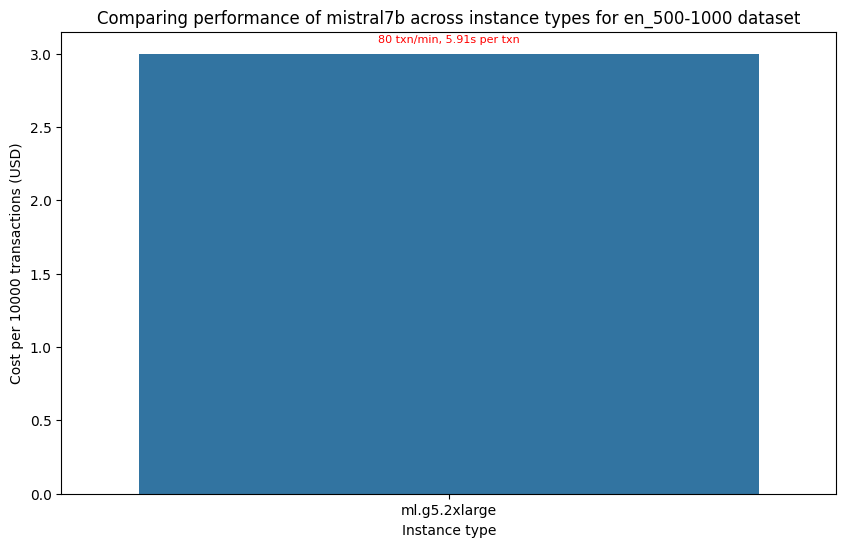

In [79]:
min_price_per_tx = df_summary_metrics_best_option_instance_type.price_per_txn.min()
count: int = 1000
multiplier: int = 10 if int(min_price_per_tx * count) == 0 else 1

price_tx_col_name = f"price_per_tx_{count*multiplier}_txn"

df_summary_metrics_best_option_instance_type[price_tx_col_name] = df_summary_metrics_best_option_instance_type.price_per_txn * 10000
df_summary_metrics_best_option_instance_type[price_tx_col_name] = df_summary_metrics_best_option_instance_type[price_tx_col_name].astype(int)
df_summary_metrics_best_option_instance_type = df_summary_metrics_best_option_instance_type.sort_values(by=price_tx_col_name)
sns_plot = sns.barplot(df_summary_metrics_best_option_instance_type, x="instance_type", y=price_tx_col_name)
title: str = f"Comparing performance of {config['general']['model_name']} across instance types for {config['metrics']['dataset_of_interest']} dataset"
sns_plot.set(xlabel="Instance type", ylabel=f"Cost per {count*multiplier} transactions (USD)", title=title)
num_instance_types = len(df_summary_metrics_dataset.instance_type.unique())
for r in df_summary_metrics_best_option_instance_type.iterrows():
    x = r[1]['instance_type']
    if num_instance_types == 1:
        v_shift = 0.1
    else:
        v_shift = 5 + 5/num_instance_types
    print(f"v_shift={v_shift}")    
    y = r[1][price_tx_col_name] + v_shift
    text = f"{r[1]['transactions_per_minute']} txn/min, {r[1]['latency_mean']}s per txn"
    print(f"x={x}, y={y}, text={text}")
    sns_plot.text(x, y, text, 
       fontsize = 8,          # Size
       #fontstyle = "oblique",  # Style
       color = "red",          # Color
       ha = "center", # Horizontal alignment
       va = "center") # Vertical alignment 

business_summary_plot_fpath: str = os.path.join(METRICS_DIR, BUSINESS_SUMMARY_PLOT_FNAME)
sns_plot.figure.savefig(business_summary_plot_fpath, format='png')
buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, business_summary_plot_fpath)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{business_summary_plot_fpath}")

## Display the plot 
sns_plot

In [80]:
display(df_summary_metrics_best_option_instance_type)

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute,price_per_hour,price_per_txn,score,price_per_tx_10000_txn
4,mistral-7b-g5-huggingface-pytorch-tgi-inferenc...,payload_en_500-1000.jsonl,ml.g5.2xlarge,8,0.0,980,1317,100,134,5.91,80,1.515,0.000316,1584.243018,3


In [81]:
BUSINESS_SUMMARY: str = """We did performance benchmarking for the `{model_name}` model on "{instance_types}" instance{plural} on multiple datasets and based on the test results the best price performance for dataset `{ds}` is provided by the `{selected_instance_type}` instance type.  {mkdn_table}

The price performance comparison for different instance types is presented below:

![Price performance comparison]({business_summary_plot_fpath})

The configuration used for these tests is available in the [`config`]({cfg_file_path}) file.
"""

from tomark import Tomark
transposed_list = []
best_instance_type_info = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]
del best_instance_type_info["score"]
for k,v in best_instance_type_info.items():
    transposed_list.append({"Information": k, "Value": v})
mkdn_table = Tomark.table(transposed_list)
mkdn_table


plural = "s" if len(df_summary_metrics.instance_type.unique()) > 1 else ""
instance_types_md = ", ".join([f"`{it}`" for it in df_summary_metrics.instance_type.unique()])
selected_instance_type: str = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]['instance_type']
ds: str = config['metrics']['dataset_of_interest']
business_summary: str = BUSINESS_SUMMARY.format(model_name=config['general']['model_name'],
                                              instance_types=instance_types_md,
                                              plural=plural,
                                              ds=ds,
                                              selected_instance_type=selected_instance_type,
                                              mkdn_table="\n" + mkdn_table,
                                              cfg_file_path=os.path.basename(CONFIG_FILE),
                                              business_summary_plot_fpath=BUSINESS_SUMMARY_PLOT_FNAME
                                              )
business_summary

'We did performance benchmarking for the `mistral7b` model on "`ml.g5.2xlarge`" instance on multiple datasets and based on the test results the best price performance for dataset `en_500-1000` is provided by the `ml.g5.2xlarge` instance type.  \n| Information | Value |\n|-----|-----|\n| experiment_name | mistral-7b-g5-huggingface-pytorch-tgi-inference-2.0.1-tgi1.1.0 |\n| payload_file | payload_en_500-1000.jsonl |\n| instance_type | ml.g5.2xlarge |\n| concurrency | 8 |\n| error_rate | 0.0 |\n| prompt_token_count_mean | 980 |\n| prompt_token_throughput | 1317 |\n| completion_token_count_mean | 100 |\n| completion_token_throughput | 134 |\n| latency_mean | 5.91 |\n| transactions_per_minute | 80 |\n| price_per_hour | 1.515 |\n| price_per_txn | 0.0003 |\n\n\nThe price performance comparison for different instance types is presented below:\n\n![Price performance comparison](business_summary.png)\n\nThe configuration used for these tests is available in the [`config`](config-mistral-7b-tgi-g5

In [82]:
from typing import Optional
dttm = str(datetime.utcnow())
#RESULT_ROW: str = "|`{dataset}`|`{instance_type}`|{desc}|"
#RESULT_DESC: str = """The best option for staying within a latency budget of `{latency_budget} seconds` on a `{instance_type}` for the `{dataset}` dataset is a `concurrency level of {concurrency}`. A concurrency level of {concurrency} achieves an `average latency of {latency_mean} seconds`, for an `average prompt size of {prompt_size} tokens` and `completion size of {completion_size} tokens` with `{tpm} transactions/minute`."""

overall_results_md = OVERALL_RESULTS_MD.format(dttm=dttm,
                                               business_summary=business_summary)
results_group_cols: List[str] = ['instance_type', 'payload_file']
result_rows: List[str] = []
for row in df_summary_metrics[results_group_cols].drop_duplicates().iterrows():
    instance_type = row[1]['instance_type']
    dataset = row[1]['payload_file']
    df_summary_metrics_nz_subset = df_summary_metrics_nz[(df_summary_metrics_nz.instance_type == instance_type) &
                                                          (df_summary_metrics_nz.payload_file == dataset) &
                                                           (df_summary_metrics_nz.latency_mean <= LATENCY_BUDGET)]
    num_results = df_summary_metrics_nz_subset.shape[0]
    result_row: Optional[str] = None
    if num_results > 0:
        logger.info(f"there are {num_results} options to choose the best option from for instance_type={instance_type}, dataset={dataset}")
        df_summary_metrics_nz_subset_selected = df_summary_metrics_nz_subset[df_summary_metrics_nz_subset.concurrency == df_summary_metrics_nz_subset.concurrency.max()]
        best = df_summary_metrics_nz_subset_selected.to_dict(orient='records')[0]
        # logger.info(best)
        result_desc = RESULT_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset,
                           concurrency=best['concurrency'],
                           latency_mean=best['latency_mean'],
                           prompt_size=int(best['prompt_token_count_mean']),
                           completion_size=int(best['completion_token_count_mean']),
                           tpm=int(best['transactions_per_minute']))     
        
        # logger.info(result_desc)
    else:
        logger.info(f"there are NO options to choose from for instance_type={instance_type}, dataset={dataset}")
        result_desc = RESULT_FAILURE_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset)
    result_row: str = RESULT_ROW.format(instance_type=best['instance_type'],
                                        dataset=dataset,
                                        desc=result_desc)
    result_rows.append(result_row)
        
    
    #logger.info(f"instance_type={row[0]}, payload_file={row[1]}")
overall_results_md += "\n".join(result_rows)

OVERALL_RESULTS_PLOTS_MD: str = """

## Plots

The following plots provide insights into the results from the different experiments run.

![{plot1_text}]({plot1_fname})

![{plot2_text}]({plot2_fname})

![{plot3_text}]({plot3_fname})
"""

overall_results_plots_md: str = OVERALL_RESULTS_PLOTS_MD.format(plot1_text=ERROR_RATES_PLOT_TEXT, 
                                                                plot1_fname=ERROR_RATES_PLOT_FNAME,
                                                                plot2_text=TOKENS_VS_LATENCY_PLOT_TEXT, 
                                                                plot2_fname=TOKENS_VS_LATENCY_PLOT_FNAME,
                                                                plot3_text=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_TEXT, 
                                                                plot3_fname=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)

overall_results_md += overall_results_plots_md


fpath: str = os.path.join(METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"writing final markdown to {fpath}")
Path(fpath).write_text(overall_results_md)
logger.info(overall_results_md)


# Write the CSV data to S3
write_to_s3(overall_results_md, BUCKET_NAME, "", METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"Results.md file saved to to s3://{BUCKET_NAME}/{METRICS_DIR}/{RESULTS_DESC_MD_FNAME}")

[2024-01-26 23:48:04,053] p14771 {613866550.py:19} INFO - there are 5 options to choose the best option from for instance_type=ml.g5.2xlarge, dataset=payload_en_1-500.jsonl
[2024-01-26 23:48:04,055] p14771 {613866550.py:19} INFO - there are 5 options to choose the best option from for instance_type=ml.g5.2xlarge, dataset=payload_en_500-1000.jsonl
[2024-01-26 23:48:04,056] p14771 {613866550.py:71} INFO - writing final markdown to data/metrics/mistral-7b-tgi-g5-v1/results.md
[2024-01-26 23:48:04,057] p14771 {613866550.py:73} INFO - 
# Results for performance benchmarking

**Last modified (UTC): 2024-01-27 04:48:04.050399**

## Summary

We did performance benchmarking for the `mistral7b` model on "`ml.g5.2xlarge`" instance on multiple datasets and based on the test results the best price performance for dataset `en_500-1000` is provided by the `ml.g5.2xlarge` instance type.  
| Information | Value |
|-----|-----|
| experiment_name | mistral-7b-g5-huggingface-pytorch-tgi-inference-2.0.1-tg

Data successfully written to s3://fmbt/data/metrics/mistral-7b-tgi-g5-v1/results.md
